In [1]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm
from statistics import mean
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.nn.functional import threshold, normalize
from torchvision.utils import save_image
import src.utils as utils
from src.dataloader import DatasetSegmentation, collate_fn
from src.processor import Samprocessor
from src.segment_anything import build_sam_vit_b, SamPredictor
from src.lora import LoRA_sam
import matplotlib.pyplot as plt
import yaml
import torch.nn.functional as F
import shutil

In [2]:
 
# Load Predictor
import matplotlib.image as mpimg

with open("/teamspace/studios/this_studio/Sam_LoRA/config.yaml", "r") as ymlfile:
   config_file = yaml.load(ymlfile, Loader=yaml.Loader)

lora = torch.load(config_file["SAM"]["CHECKPOINT"])
#print(lora)
# Load SAM model
processor = Samprocessor(lora.sam)



predictor = SamPredictor(lora.sam)


In [56]:
def convert_path(sample_path):
    # Split the sample path to isolate the filename
    parts = sample_path.split('/')
    filename = parts[-1]
    
    # Remove the file extension from the filename
    name, ext = filename.rsplit('.', 1)
    
    # Append '_binarymask' to the filename
    new_name = f"{name}_binarymask.{ext}"
    
    # Replace 'samples' with 'binary_masks' in the path
    parts[-2] = 'binary_masks'
    
    # Replace the filename with the new filename
    parts[-1] = new_name
    
    # Join the parts back into a single path
    new_path = '/'.join(parts)
    return new_path

def add_label(img_path, mask, dest_folder = '/teamspace/studios/this_studio/discriminator_false_label/dataset'):
    do = input('add it to dataset?')
    if do == '':
        img_name = img_path.split('/')[-1]  # with the extension
        filename, ext = img_name.rsplit('.', 1)    # filename is without the extension
        mask_name = f"{filename}_binarymask.{ext}" # with the extension
        shutil.copy(img_path, os.path.join(dest_folder,'samples' ,img_name))
        mask = Image.fromarray(mask*255)
        mask.save(os.path.join(dest_folder, 'binary_masks', mask_name))
        #shutil.copy(convert_path(img_path), os.path.join(dest_folder, 'binary_masks', mask_name))
        with open(os.path.join(dest_folder, 'labels', f"{filename}_label.txt"),'w') as f:
            f.write('1')
        print('added as a good sample')
    elif do == 'b':
        img_name = img_path.split('/')[-1]  # with the extension
        filename, ext = img_name.rsplit('.', 1)    # filename is without the extension
        mask_name = f"{filename}_binarymask.{ext}" # with the extension
        shutil.copy(img_path, os.path.join(dest_folder,'samples' ,img_name))
        mask = (mask*255).astype(np.uint8)
        mask = Image.fromarray(mask)
        mask.save(os.path.join(dest_folder, 'binary_masks', mask_name))
        with open(os.path.join(dest_folder, 'labels', f"{filename}_label.txt"),'w') as f:
            f.write('0') 
        print('added as a bad sample')
    else:
        print('passed')
            
        


In [4]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/teamspace/studios/this_studio/Deeplab/db_urls_random_1000.csv')['URL']

live_database_urls = df.tolist()
print(len(live_database_urls))
print(live_database_urls[0])

1149
https://treetracker-production-images.s3.eu-central-1.amazonaws.com/2022.02.25.03.34.05_8.4412_-13.181799999999999_9685a0a5-bf9b-421e-9f95-3ea39a28dc33_IMG_20220222_222020_8688751195411927225.jpg


In [76]:
class SAMMaskExtractor:
    def __init__(self, predictor, path):
        self.predictor = predictor
        self.path = path
        self.masks = []

    def getmask(self):
        return self.masks

    def generate(self, img_path):
        img = Image.open(img_path)
        img = np.array(img)
        self.predictor.set_image(img)
        input_box = np.array([0,0,img.shape[0],img.shape[1]])
        masks, scores, logits = self.predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        self.show_mask(masks[0], plt.gca())
        plt.axis('on')
        plt.show()
        self.masks.append(masks[0])
        print(scores[0])


    @staticmethod
    def show_mask(mask, ax):
        ax.imshow(mask, alpha=0.5, cmap='viridis')

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

        

In [9]:
import random
import os
from PIL import Image
india_samples_location = '/teamspace/studios/this_studio/Deeplab/india_sam_dino_annotations/samples'
sample_list_india = [os.path.join(india_samples_location, i) for i in os.listdir(india_samples_location)]
freetown_haiti_afrifa_location = '/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples'
sample_list_other = [os.path.join(freetown_haiti_afrifa_location, i) for i in os.listdir(freetown_haiti_afrifa_location)]
inhouse_samples = []
inhouse_samples.extend(sample_list_india)
inhouse_samples.extend(sample_list_other)
print(len(inhouse_samples))
random_samples = random.sample(inhouse_samples, 50)

500


In [66]:
i = 11

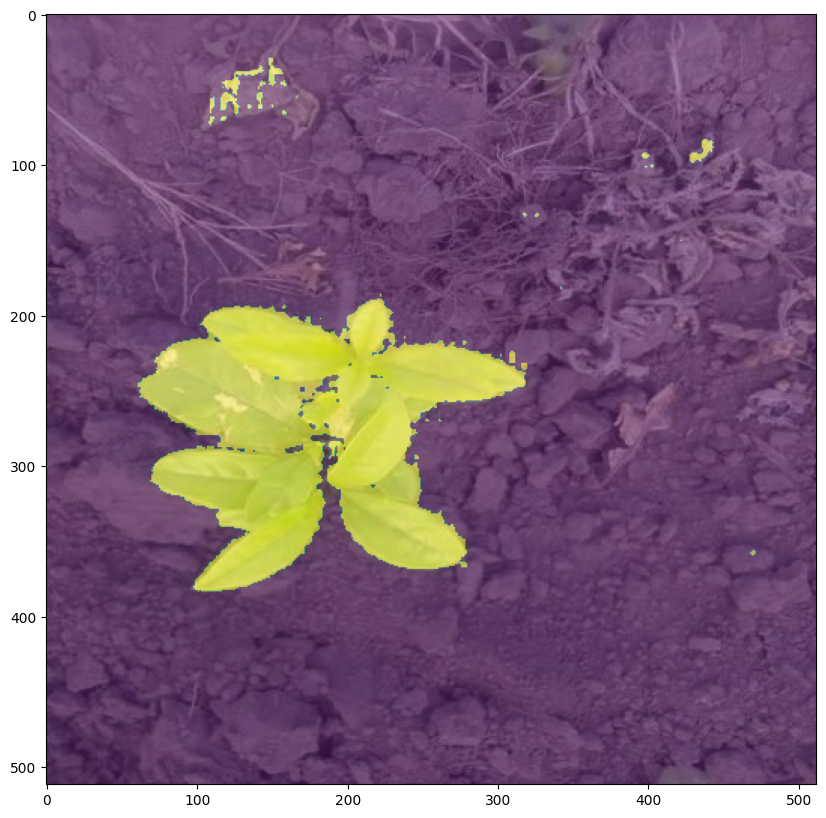

0.74901503
/teamspace/studios/this_studio/Deeplab/crf_sam_annotations/samples/eastafrica_oleacape_2020.06.02.13.02.28_880e6d7b-f78c-4504-b065-edb009a0fdae_img_20200529_160356_266103701.jpg


add it to dataset? m


passed
107


In [165]:

mask_extractor = SAMMaskExtractor(predictor,sample_list_other[i])
mask_extractor.generate(sample_list_other[i])
masks = mask_extractor.getmask()
print(sample_list_other[i])


#plt.imshow(img)
#print(masks*255)

add_label(sample_list_other[i],masks[0])

print(i)
i+=1
